# Bond Sensitivities

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd

## Building the Yield Curve

Before any bond pricing can be done, the discount factors must be extrapolated from existing information we have on the yield curve.

In [30]:
# building interest rates
# T is yearly
# Read tables from a webpage
tables = pd.read_html('https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2025')

In [74]:
yesterday_info = tables[0].iloc[-1]

In [78]:
maturities = [1/12, 1.5/12, 2/12, 3/12, 4/12, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]
yields = yesterday_info.to_list()[12:]

In [86]:
# Cubic spline is a popular method for Term Structure of Interest Rate Curve to Existing yields
from scipy.interpolate import CubicSpline
cs = CubicSpline(maturities, yields, bc_type='natural')

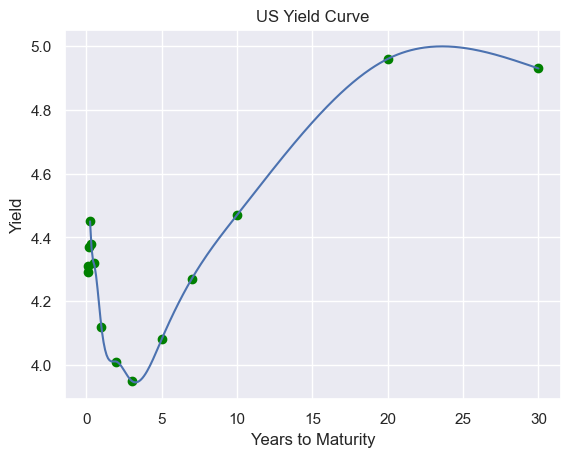

In [124]:
x_new = np.linspace(0.25, 30, 300)
y_new = cs(x_new)
plt.scatter(maturities,yields, color='green')
plt.plot(x_new, y_new)
plt.xlabel("Years to Maturity")
plt.ylabel("Yield")
plt.title("US Yield Curve")
plt.show()

## Building Bonds

In [457]:
class Bond:
    def __init__(self, term_structure, coupon_rate=0.05, coupon_period=0.5, ttm=10, face_value=100):
        self.coupon_rate = coupon_rate
        self.coupon_period = coupon_period
        self.ttm = ttm
        self.face_value = face_value
        #build our cash flow df
        self.df = self.get_df()
        # get the rates required to price the bond
        self.rates = term_structure(self.df['date'])/100
        # get our bond price
        self.price = self.get_price(self.rates)

    def get_df(self):
        # build bond cashflows
        cash_flows = [self.coupon_rate*self.coupon_period*self.face_value for _ in range(int(self.ttm/self.coupon_period))]
        cash_flows[-1] += self.face_value
        dates = np.arange(self.coupon_period,self.ttm+self.coupon_period,self.coupon_period)
        bond_df = pd.DataFrame({'date':dates, 'cash_flow':cash_flows})
        return bond_df

    # shift is bps
    def get_price(self, rates):
        discount_factors = (1 + rates*self.coupon_period)**(-1 * self.df['date']/self.coupon_period)
        price = sum(discount_factors * self.df['cash_flow'])
        return price

In [459]:
x = Bond(cs)

In [471]:
shifts = np.arange(-0.04, 0.04, 1/1_000)
new_price = np.array([x.get_price(x.rates + shift) for shift in shifts])

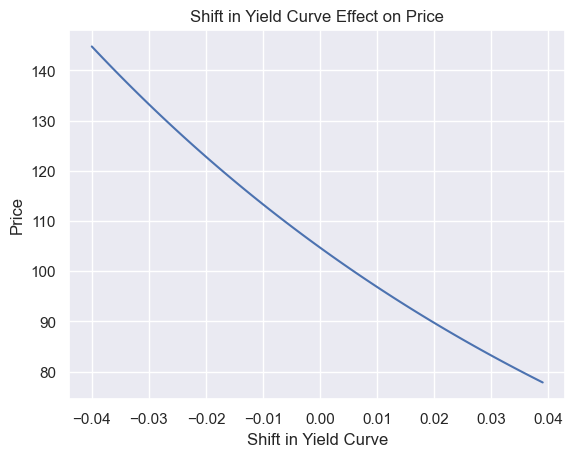

In [483]:
plt.plot(shifts, new_price)
plt.xlabel("Shift in Yield Curve")
plt.ylabel("Price")
plt.title("Shift in Yield Curve Effect on Price")
plt.show()

We must define the bond price as a function of a shift in the term structure ($r$):
$$ B(r,T) = \sum_{i=1}^n \frac{C_{T_i}}{(1 + r_1(T_i) + r)^{T_i}} + \frac{100}{(1 + r_1(T_n) + r)^{T_n}},$$
where $r_1(\cdot)$ is the one period rate for time $T_i$. These cash flows can be seen in the bonds dataframe where $r=0$.

In [498]:
x.df.tail()

,date,cash_flow
15,8.0,2.5
16,8.5,2.5
17,9.0,2.5
18,9.5,2.5
19,10.0,102.5


We can now differential with respect to the change in spot rate to get the bonds sensitivity:

$$ \frac{\partial B(r,T)}{\partial r} = -1 * \sum_{i=1}^n \frac{C_{T_i} * T_i}{(1 + r_1(T_i))^{T_i + 1}} + \frac{100 * T_n}{(1 + r_1(T_n))^{T_n + 1}}.$$

In [539]:
deriv_df = x.df

In [541]:
deriv_df['rate'] = x.rates

In [543]:
deriv_df['frac'] = dur_df['cash_flow'] * dur_df['date'] / (1 + dur_df['rate']*x.coupon_period)**(dur_df['date'] + 1)

In [545]:
deriv = -1*sum(deriv_df['frac'])

In [551]:
print(f'Derivative of bond price w.r.t spot rate: {deriv}.')

Derivative of bond price w.r.t spot rate: -1006.7145786995441.


As we can see, the sensitivty of the bond price to a shifts in the interest rate curve is $\$-1,000$! That is quite large, but it is important to note that the interest rate moves in terms of basis points (bps) where a single bp is $0.01\%$ or $0.0001$, so the sensitivity is normally quoted in terms of bps:

$$\frac{1}{10,000}\frac{\partial B(r,T)}{\partial r}$$

In [558]:
deriv = deriv * (1/10_000)
print(f'Derivative of bond price w.r.t spot rate: {deriv}.')

Derivative of bond price w.r.t spot rate: -0.1006714578699544.


This is a more intuitive and helpful value, if the term structure of interest rates shifts up one basis point, then we should expect the price of our bond to decrease by about $10$ cents.

## Duration

Now that we have our bonds sensitivty to shifts in the interest rate curve, we can observe the bonds **Duration**. The different duration measures of a bond are very closely related to the sensitivity of the bond to shifts in the term structure, but they differ due to "not letting enough math people be involved with bonds from the get to" as one of my old professors explained.

### Dollar Duration (DV01)

$$ -1 * \frac{1}{10,000}\frac{\partial B(r,T)}{\partial r}$$

In [575]:
DV01 = deriv * -1
print(f'DV01 of bond: {DV01}')

DV01 of bond: 0.1006714578699544


Yes, the dollar duration is just the negative of the sensitivty to a bp change. This does nothing other than allow us to think of duration as "amount to lose" instead of "amount to change".